In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
from matplotlib.colors import LogNorm
from models import *

class ModelSimilarityAnalyzer:
    def __init__(self, models, model_names=None):
        self.models = models
        self.model_names = model_names or [f"Model_{i}" for i in range(len(models))]
        self.n_models = len(models)
        self.similarity_matrix = None
        self.distance_matrix = None
        self.embeddings_2d = None

    def extract_features(self, model, dataloader, device='cuda'):
        """Extract features from a model"""
        features = []
        model.eval()
        with torch.no_grad():
            for batch in dataloader:
                if isinstance(batch, (list, tuple)):
                    inputs = batch[0].to(device)
                else:
                    inputs = batch.to(device)

                # Try to get features from penultimate layer
                # Adjust this based on your model architecture
                try:
                    # Option 1: If model has feature_extractor method
                    representations = model.feature_extractor(inputs)
                except AttributeError:
                    try:
                        # Option 2: If model has features attribute
                        representations = model.features(inputs)
                        representations = representations.view(representations.size(0), -1)
                    except AttributeError:
                        # Option 3: Forward pass and get second-to-last layer
                        representations = model(inputs)
                        if len(representations.shape) > 2:
                            representations = representations.view(representations.size(0), -1)

                features.append(representations.cpu().numpy())

        return np.concatenate(features, axis=0)

    def center_kernel(self, K):
        """Center a kernel matrix"""
        n = K.shape[0]
        H = np.eye(n) - np.ones((n, n)) / n
        return H @ K @ H

    def get_knn_structure(self, kernel_matrix, k):
        """Extract k-nearest neighbor structure"""
        knn_indices = np.argsort(-kernel_matrix, axis=1)[:, 1:k+1]
        return knn_indices

    def compute_cknna(self, knn_A, knn_B, k):
        """Compute CKNNA between two k-NN structures"""
        n_samples = knn_A.shape[0]
        alignment_scores = []

        for i in range(n_samples):
            neighbors_A = set(knn_A[i])
            neighbors_B = set(knn_B[i])
            intersection = len(neighbors_A.intersection(neighbors_B))
            overlap_ratio = intersection / k
            alignment_scores.append(overlap_ratio)

        return np.mean(alignment_scores)

    def compute_similarity_matrix(self, dataloader, k=10, device='cuda', kernel_type='cosine',
                                 memory_mode='low', batch_size=None, save_features=False,
                                 features_dir='./model_features'):
        """
        Compute CKNNA similarity matrix between all model pairs with memory management

        Args:
            memory_mode: 'low', 'medium', 'high' - controls memory vs speed tradeoff
            batch_size: For chunked processing in low memory mode
            save_features: Whether to save features to disk to avoid recomputation
            features_dir: Directory to save/load features
        """
        import os
        import gc

        if save_features:
            os.makedirs(features_dir, exist_ok=True)

        print("Computing pairwise CKNNA similarities...")
        similarity_matrix = np.zeros((self.n_models, self.n_models))

        if memory_mode == 'high':
            # Original approach - keep everything in memory
            return self._compute_high_memory(dataloader, k, device, kernel_type)

        elif memory_mode == 'medium':
            # Keep features, compute kernels on-demand
            return self._compute_medium_memory(dataloader, k, device, kernel_type,
                                             save_features, features_dir)

        else:  # low memory mode
            # Process in batches, minimal memory footprint
            batch_size = batch_size or max(1, self.n_models // 10)  # Default to 10% batches
            return self._compute_low_memory(dataloader, k, device, kernel_type,
                                          batch_size, save_features, features_dir)

    def _compute_high_memory(self, dataloader, k, device, kernel_type):
        """Original high-memory approach"""
        # Extract features from all models
        all_features = []
        for i, model in enumerate(tqdm(self.models, desc="Extracting features")):
            features = self.extract_features(model, dataloader, device)
            all_features.append(features)

        # Compute kernel matrices for all models
        all_kernels = []
        for features in tqdm(all_features, desc="Computing kernels"):
            K = self._compute_kernel(features, kernel_type)
            K_centered = self.center_kernel(K)
            all_kernels.append(K_centered)

        # Compute k-NN structures
        all_knn = []
        for K in tqdm(all_kernels, desc="Computing k-NN structures"):
            knn = self.get_knn_structure(K, k)
            all_knn.append(knn)

        return self._compute_pairwise_scores(all_knn, k)

    def _compute_medium_memory(self, dataloader, k, device, kernel_type, save_features, features_dir):
        """Medium memory approach - keep features, compute kernels on demand"""
        import gc

        # Extract or load features
        all_features = []
        for i, model in enumerate(tqdm(self.models, desc="Extracting/Loading features")):
            feature_path = os.path.join(features_dir, f"model_{i}_features.npy") if save_features else None

            if save_features and os.path.exists(feature_path):
                features = np.load(feature_path)
            else:
                features = self.extract_features(model, dataloader, device)
                if save_features:
                    np.save(feature_path, features)

            all_features.append(features)

        # Compute k-NN structures on demand
        all_knn = []
        for i, features in enumerate(tqdm(all_features, desc="Computing k-NN structures")):
            K = self._compute_kernel(features, kernel_type)
            K_centered = self.center_kernel(K)
            knn = self.get_knn_structure(K_centered, k)
            all_knn.append(knn)

            # Clean up large matrices
            del K, K_centered
            gc.collect()

        return self._compute_pairwise_scores(all_knn, k)

    def _compute_low_memory(self, dataloader, k, device, kernel_type, batch_size, save_features, features_dir):
        """Low memory approach - process in batches"""
        import gc

        similarity_matrix = np.zeros((self.n_models, self.n_models))

        # Process models in batches
        for batch_start in tqdm(range(0, self.n_models, batch_size), desc="Processing batches"):
            batch_end = min(batch_start + batch_size, self.n_models)
            batch_indices = list(range(batch_start, batch_end))

            # Load batch features and compute k-NN structures
            batch_knn = []
            for i in batch_indices:
                feature_path = os.path.join(features_dir, f"model_{i}_features.npy") if save_features else None

                if save_features and os.path.exists(feature_path):
                    features = np.load(feature_path)
                else:
                    features = self.extract_features(self.models[i], dataloader, device)
                    if save_features:
                        os.makedirs(features_dir, exist_ok=True)
                        np.save(feature_path, features)

                K = self._compute_kernel(features, kernel_type)
                K_centered = self.center_kernel(K)
                knn = self.get_knn_structure(K_centered, k)
                batch_knn.append(knn)

                # Clean up
                del features, K, K_centered
                gc.collect()

            # Compare with all other models (including other batches)
            for other_start in range(batch_start, self.n_models, batch_size):
                other_end = min(other_start + batch_size, self.n_models)
                other_indices = list(range(other_start, other_end))

                if other_start == batch_start:
                    # Same batch - use already computed k-NN structures
                    other_knn = batch_knn
                else:
                    # Different batch - compute k-NN structures
                    other_knn = []
                    for j in other_indices:
                        feature_path = os.path.join(features_dir, f"model_{j}_features.npy") if save_features else None

                        if save_features and os.path.exists(feature_path):
                            features = np.load(feature_path)
                        else:
                            features = self.extract_features(self.models[j], dataloader, device)
                            if save_features:
                                np.save(feature_path, features)

                        K = self._compute_kernel(features, kernel_type)
                        K_centered = self.center_kernel(K)
                        knn = self.get_knn_structure(K_centered, k)
                        other_knn.append(knn)

                        del features, K, K_centered
                        gc.collect()

                # Compute pairwise scores for this batch combination
                for local_i, i in enumerate(batch_indices):
                    for local_j, j in enumerate(other_indices):
                        if i == j:
                            similarity_matrix[i, j] = 1.0
                        elif i < j:  # Only compute upper triangle
                            cknna_score = self.compute_cknna(batch_knn[local_i], other_knn[local_j], k)
                            similarity_matrix[i, j] = cknna_score
                            similarity_matrix[j, i] = cknna_score

                # Clean up other_knn if it was computed
                if other_start != batch_start:
                    del other_knn
                    gc.collect()

            # Clean up batch data
            del batch_knn
            gc.collect()

        self.similarity_matrix = similarity_matrix
        self.distance_matrix = 1 - similarity_matrix
        return similarity_matrix

    def _compute_kernel(self, features, kernel_type):
        """Helper to compute kernel matrix"""
        if kernel_type == 'cosine':
            return cosine_similarity(features)
        elif kernel_type == 'linear':
            return features @ features.T
        else:  # rbf
            from sklearn.metrics.pairwise import rbf_kernel
            return rbf_kernel(features)

    def _compute_pairwise_scores(self, all_knn, k):
        """Compute pairwise CKNNA scores from k-NN structures"""
        similarity_matrix = np.zeros((self.n_models, self.n_models))

        for i in tqdm(range(self.n_models), desc="Computing CKNNA pairs"):
            for j in range(i, self.n_models):
                if i == j:
                    similarity_matrix[i, j] = 1.0
                else:
                    cknna_score = self.compute_cknna(all_knn[i], all_knn[j], k)
                    similarity_matrix[i, j] = cknna_score
                    similarity_matrix[j, i] = cknna_score

        self.similarity_matrix = similarity_matrix
        self.distance_matrix = 1 - similarity_matrix
        return similarity_matrix

    def embed_models_2d(self, method='mds', random_state=42):
        """Embed models in 2D space based on distance matrix"""
        if self.distance_matrix is None:
            raise ValueError("Must compute similarity matrix first!")

        if method.lower() == 'mds':
            # Multidimensional Scaling
            mds = MDS(n_components=2, dissimilarity='precomputed',
                     random_state=random_state, normalized_stress='auto')
            embeddings = mds.fit_transform(self.distance_matrix)

        elif method.lower() == 'tsne':
            # t-SNE (convert distance to similarity for t-SNE)
            tsne = TSNE(n_components=2, metric='precomputed',
                       random_state=random_state, perplexity=min(30, self.n_models-1))
            embeddings = tsne.fit_transform(self.distance_matrix)

        elif method.lower() == 'pca':
            # PCA on similarity matrix
            pca = PCA(n_components=2, random_state=random_state)
            embeddings = pca.fit_transform(self.similarity_matrix)

        else:
            raise ValueError("Method must be 'mds', 'tsne', or 'pca'")

        self.embeddings_2d = embeddings
        return embeddings

    def plot_similarity_matrix(self, figsize=(12, 10), save_path=None):
        """Plot the similarity matrix as a heatmap"""
        plt.figure(figsize=figsize)
        sns.heatmap((self.similarity_matrix + 0.001),
                    norm = LogNorm(),
                   xticklabels=self.model_names,
                   yticklabels=self.model_names,
                   annot=False, cmap='viridis',
                   square=True, cbar_kws={'label': 'CKNNA Similarity'})
        plt.title('Model Similarity Matrix (CKNNA)')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    def plot_2d_embedding(self, method='mds', figsize=(12, 10), save_path=None, interactive=False):
        """Plot 2D embedding of models"""
        if self.embeddings_2d is None:
            self.embed_models_2d(method=method)

        if interactive:
            # Interactive plot with Plotly
            fig = go.Figure()

            fig.add_trace(go.Scatter(
                x=self.embeddings_2d[:, 0],
                y=self.embeddings_2d[:, 1],
                mode='markers+text',
                marker=dict(size=10, color='red'),
                text=self.model_names,
                textposition="top center",
                hovertemplate='<b>%{text}</b><br>X: %{x:.3f}<br>Y: %{y:.3f}<extra></extra>'
            ))

            fig.update_layout(
                title=f'2D Model Embedding ({method.upper()})',
                xaxis_title=f'{method.upper()} Dimension 1',
                yaxis_title=f'{method.upper()} Dimension 2',
                width=800,
                height=600
            )

            fig.show()

        else:
            # Static plot with Matplotlib
            plt.figure(figsize=figsize)
            plt.scatter(self.embeddings_2d[:, 0], self.embeddings_2d[:, 1],
                       s=100, alpha=0.7, c='red')

            # Add model names as labels
            for i, name in enumerate(self.model_names):
                plt.annotate(name, (self.embeddings_2d[i, 0], self.embeddings_2d[i, 1]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

            plt.title(f'2D Model Embedding ({method.upper()})')
            plt.xlabel(f'{method.upper()} Dimension 1')
            plt.ylabel(f'{method.upper()} Dimension 2')
            plt.grid(True, alpha=0.3)

            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()

    def analyze_clusters(self, n_clusters=None):
        """Perform clustering analysis on the 2D embeddings"""
        from sklearn.cluster import KMeans, DBSCAN

        if self.embeddings_2d is None:
            raise ValueError("Must compute 2D embeddings first!")

        if n_clusters is None:
            # Use DBSCAN for automatic cluster detection
            clustering = DBSCAN(eps=0.5, min_samples=2)
            cluster_labels = clustering.fit_predict(self.embeddings_2d)
        else:
            # Use K-means with specified number of clusters
            clustering = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = clustering.fit_predict(self.embeddings_2d)

        # Plot clusters
        plt.figure(figsize=(12, 10))
        unique_labels = np.unique(cluster_labels)
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

        for label, color in zip(unique_labels, colors):
            if label == -1:  # DBSCAN noise points
                color = 'black'
                marker = 'x'
                label_name = 'Noise'
            else:
                marker = 'o'
                label_name = f'Cluster {label}'

            mask = cluster_labels == label
            plt.scatter(self.embeddings_2d[mask, 0], self.embeddings_2d[mask, 1],
                       c=[color], marker=marker, s=100, alpha=0.7, label=label_name)

            # Add model names
            for i in np.where(mask)[0]:
                plt.annotate(self.model_names[i],
                           (self.embeddings_2d[i, 0], self.embeddings_2d[i, 1]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

        plt.title('Model Clusters in 2D Space')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        return cluster_labels

# Imnet

In [2]:
import os
models = []
model_names = []
preran = ['pre', 'ran']
lrs = ['-3', '-2']
byol_hip = ['98', '996']
CHECKPOINT5_NAME = 'model_epoch_5.ckpt'
outer_byol_path = os.path.join('checkpoints_imagenet', 'byol')
for arch in preran:
    for lr in lrs:
        for hip in byol_hip:
            dir_name = arch+lr+hip
            checkpoint_path = os.path.join(outer_byol_path, dir_name, CHECKPOINT5_NAME)
            module = BYOLModel.load_from_checkpoint(checkpoint_path)
            model = module.online_backbone
            models.append(model)
            model_name = 'byol'+dir_name
            model_names.append(model_name)
mae_hip = ['75', '90']
outer_mae_path = os.path.join('checkpoints_imagenet', 'mae')
for arch in preran:
    for lr in lrs:
        for hip in mae_hip:
            dir_name = arch+lr+hip
            checkpoint_path = os.path.join(outer_mae_path, dir_name, CHECKPOINT5_NAME)
            module = MAEModel.load_from_checkpoint(checkpoint_path)
            model = module.encoder.backbone
            models.append(model)
            model_name = 'mae'+dir_name
            model_names.append(model_name)
outer_simclr_path = os.path.join('checkpoints_imagenet', 'simclr')
for arch in preran:
    for lr in lrs:
        dir_name = arch+lr
        checkpoint_path = os.path.join(outer_simclr_path, dir_name, CHECKPOINT5_NAME)
        module = SimCLRModel.load_from_checkpoint(checkpoint_path)
        model = module.backbone
        models.append(model)
        model_name = 'simclr'+dir_name
        model_names.append(model_name)






/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.wa

In [3]:
model_names

['byolpre-398',
 'byolpre-3996',
 'byolpre-298',
 'byolpre-2996',
 'byolran-398',
 'byolran-3996',
 'byolran-298',
 'byolran-2996',
 'maepre-375',
 'maepre-390',
 'maepre-275',
 'maepre-290',
 'maeran-375',
 'maeran-390',
 'maeran-275',
 'maeran-290',
 'simclrpre-3',
 'simclrpre-2',
 'simclrran-3',
 'simclrran-2']

In [3]:
analyzer = ModelSimilarityAnalyzer(models, model_names)

In [4]:
NUM_WORKERS = 4
BATCH_SIZE = 128

In [5]:
import pickle

with open("train_full_imagenet_mae.pkl", "rb") as f:
    train_full_imagenet_mae = pickle.load(f)

with open("train_ssl_imagenet_mae.pkl", "rb") as f:
    train_ssl_imagenet_mae = pickle.load(f)

with open("train_imagenet_mae.pkl", "rb") as f:
    train_imagenet_mae = pickle.load(f)

with open("test_imagenet_mae.pkl", "rb") as f:
    test_imagenet_mae = pickle.load(f)

/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
len(test_imagenet_mae)

50000

In [7]:
from torch.utils.data import DataLoader
test_dl = DataLoader(torch.utils.data.Subset(test_imagenet_mae, np.arange(10000)), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True)

In [8]:
similarity_matrix = analyzer.compute_similarity_matrix(
    dataloader=test_dl,
    k=3,
    device='cuda',
    memory_mode = 'medium',
    save_features = False
)

Computing pairwise CKNNA similarities...


Computing CKNNA pairs: 100%|██████████| 20/20 [00:03<00:00,  5.71it/s]


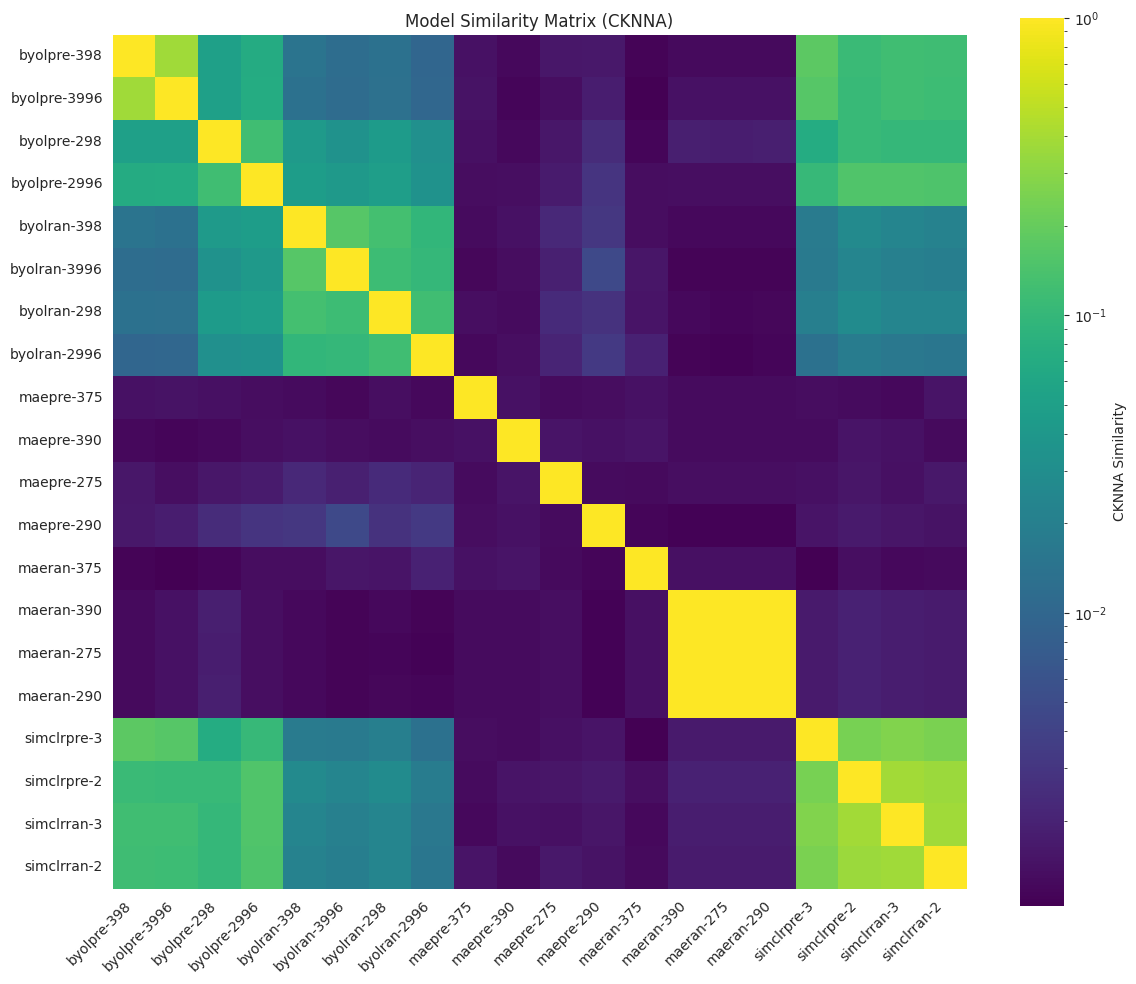

In [9]:
analyzer.plot_similarity_matrix()

In [10]:
analyzer.plot_2d_embedding(method='mds', interactive=True)

/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


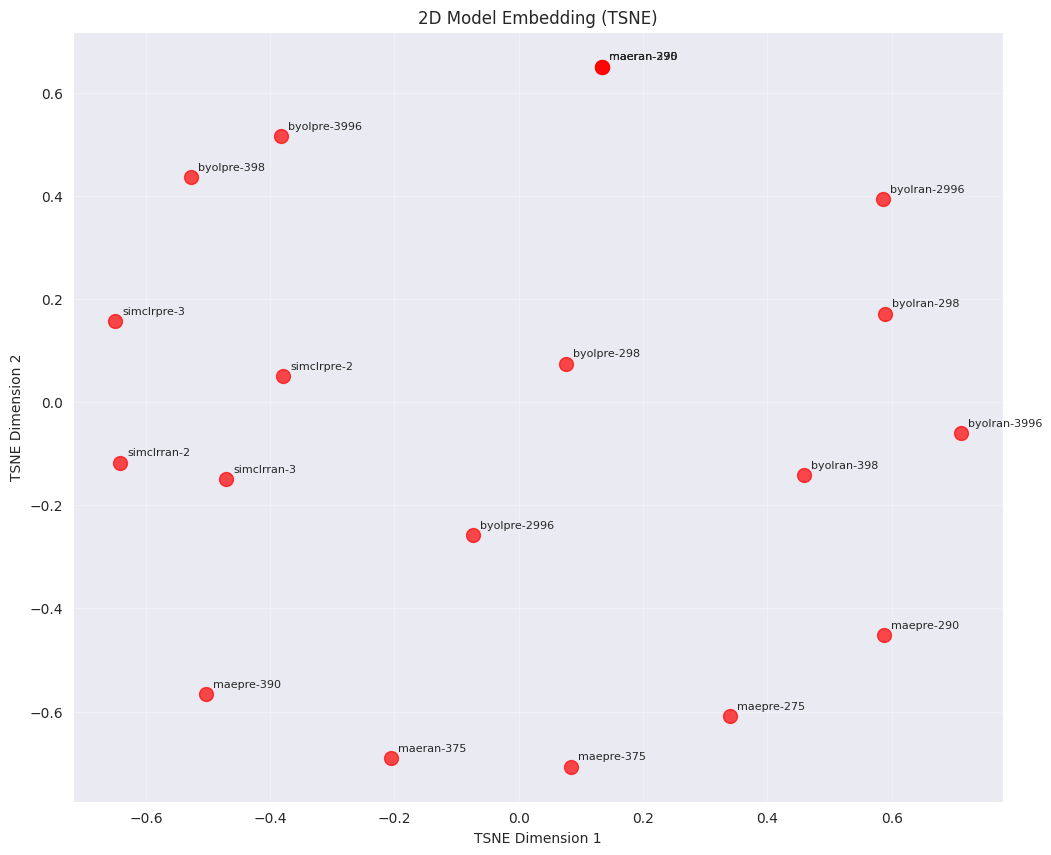

In [11]:
analyzer.plot_2d_embedding(method='tsne')


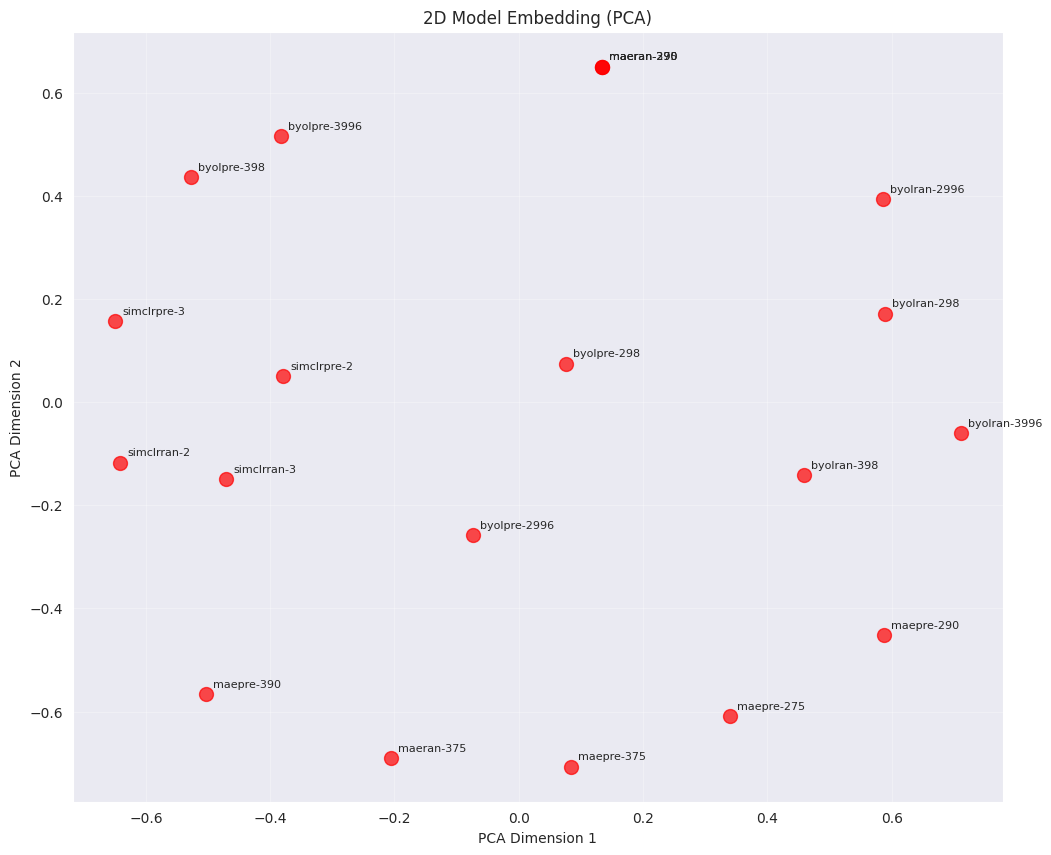

In [12]:
analyzer.plot_2d_embedding(method='pca')

# CIFAR100

In [2]:
import os
models = []
model_names = []
preran = ['pre', 'ran']
lrs = ['-3', '-2']
byol_hip = ['98', '996']
CHECKPOINT5_NAME = 'model_epoch_15.ckpt'
outer_byol_path = os.path.join('checkpoints_100', 'byol')
for arch in preran:
    for lr in lrs:
        for hip in byol_hip:
            dir_name = arch+lr+hip
            checkpoint_path = os.path.join(outer_byol_path, dir_name, CHECKPOINT5_NAME)
            module = BYOLModel.load_from_checkpoint(checkpoint_path)
            model = module.online_backbone
            models.append(model)
            model_name = 'byol'+dir_name
            model_names.append(model_name)
mae_hip = ['75', '90']
outer_mae_path = os.path.join('checkpoints_100', 'mae')
for arch in preran:
    for lr in lrs:
        for hip in mae_hip:
            dir_name = arch+lr+hip
            checkpoint_path = os.path.join(outer_mae_path, dir_name, CHECKPOINT5_NAME)
            module = MAEModel.load_from_checkpoint(checkpoint_path)
            model = module.encoder.backbone
            models.append(model)
            model_name = 'mae'+dir_name
            model_names.append(model_name)
outer_simclr_path = os.path.join('checkpoints_100', 'simclr')
for arch in preran:
    for lr in lrs:
        dir_name = arch+lr
        checkpoint_path = os.path.join(outer_simclr_path, dir_name, CHECKPOINT5_NAME)
        module = SimCLRModel.load_from_checkpoint(checkpoint_path)
        model = module.backbone
        models.append(model)
        model_name = 'simclr'+dir_name
        model_names.append(model_name)

/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.wa

In [3]:
analyzer = ModelSimilarityAnalyzer(models, model_names)
NUM_WORKERS = 4
BATCH_SIZE = 128

In [4]:
from lightly.transforms import utils
from torchvision import transforms as T
test_transform = T.v2.Compose(
    [
        T.Resize((224, 224)),
        T.v2.ToImage(),
        T.v2.ToDtype(torch.float32, scale=True),
        T.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        )
    ]
)
scratch_transform = T.v2.Compose(
    [
        T.RandomResizedCrop((224, 224)),
        T.RandomHorizontalFlip(),
        T.v2.ToImage(),
        T.v2.ToDtype(torch.float32, scale=True),
        T.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        )
    ]
)


/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
from datasets import create_dataset
train_full_cifar100_mae, train_ssl_cifar100_mae, train_cifar100_mae, test_cifar100_mae, targets_cifar100 = create_dataset("CIFAR100", 0.9, scratch_transform, scratch_transform, test_transform, "data", False)

Length of entire train dataset:  50000
Length of SSL train dataset:  45000
Length of classification train dataset:  5000
Length of test dataset:  10000


In [6]:
from torch.utils.data import DataLoader
test_dl = DataLoader(test_cifar100_mae, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True)

In [7]:
similarity_matrix = analyzer.compute_similarity_matrix(
    dataloader=test_dl,
    k=3,
    device='cuda',
    memory_mode = 'medium',
    save_features = False
)

Computing pairwise CKNNA similarities...


Computing CKNNA pairs: 100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


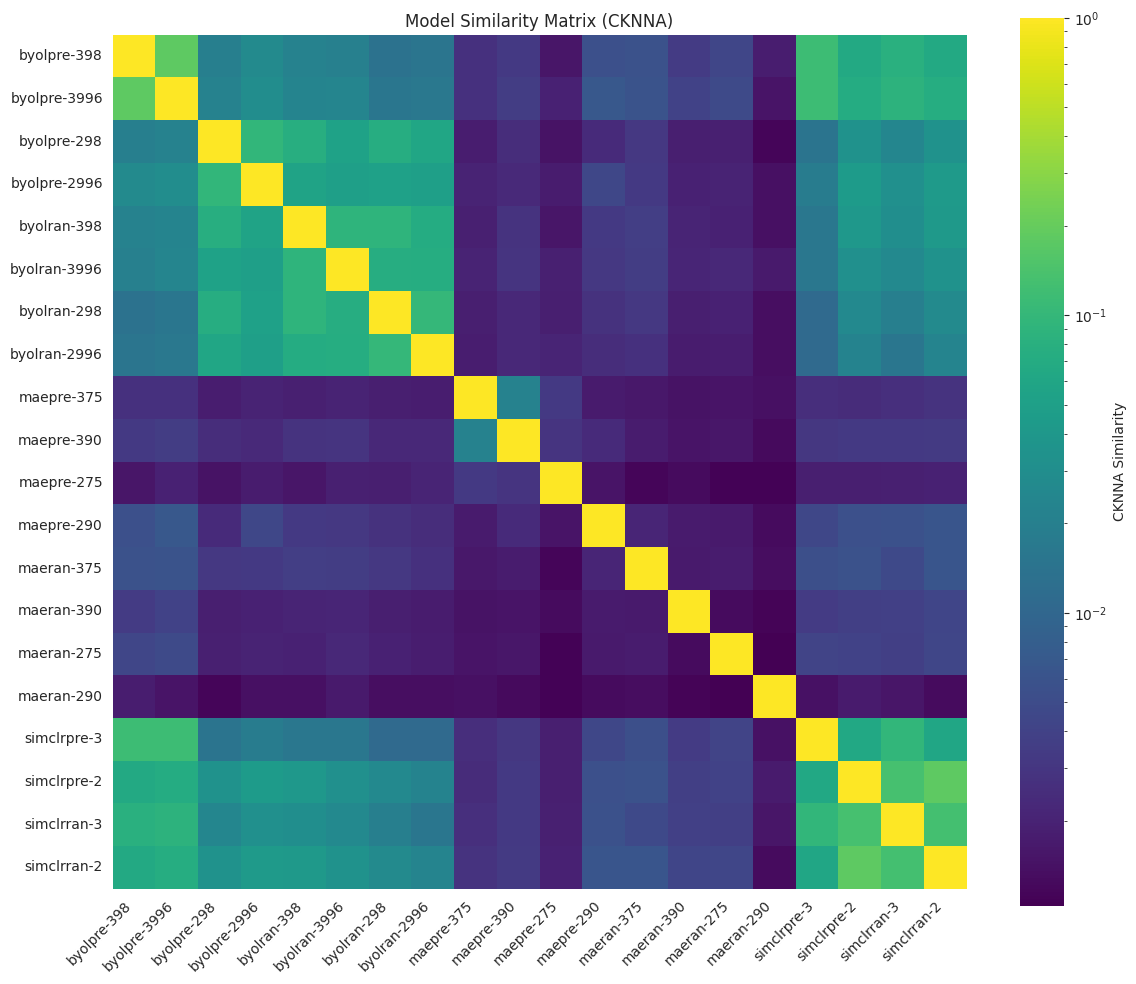

In [8]:
analyzer.plot_similarity_matrix()

In [9]:
analyzer.plot_2d_embedding(method='mds', interactive=True)

/home/hussein/python_venvs/na_ratunek_venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


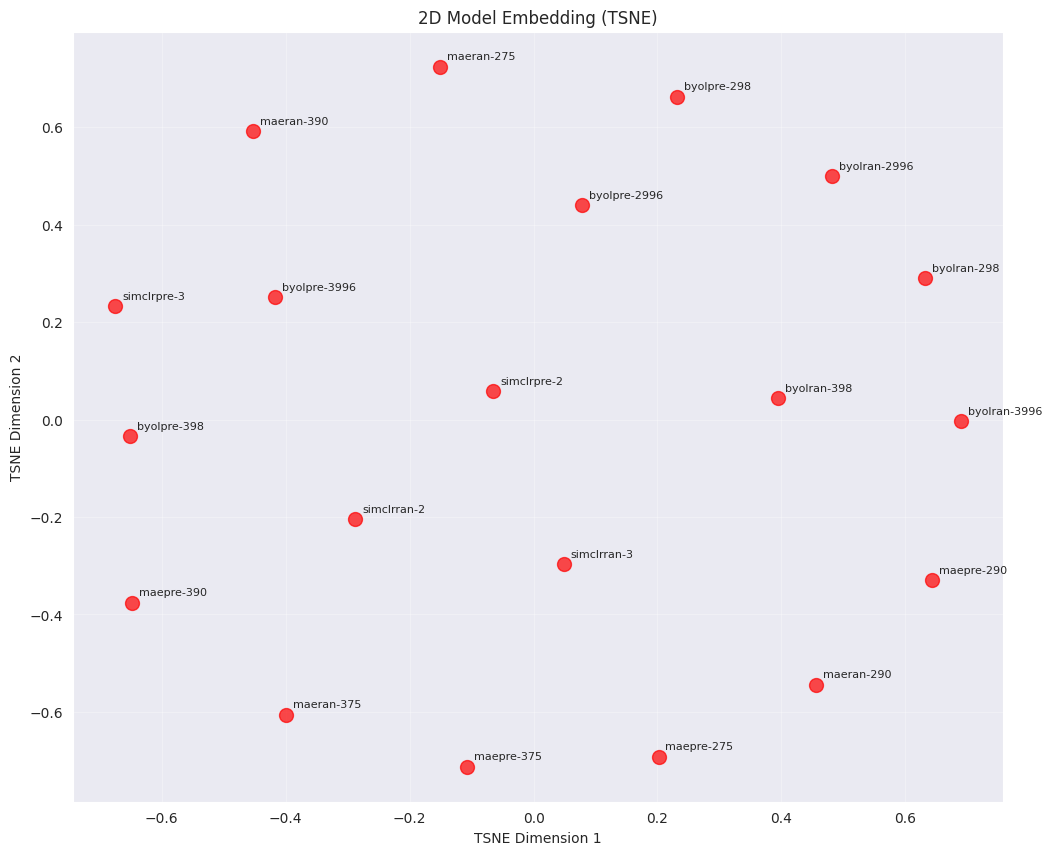

In [10]:
analyzer.plot_2d_embedding(method='tsne', interactive=False)

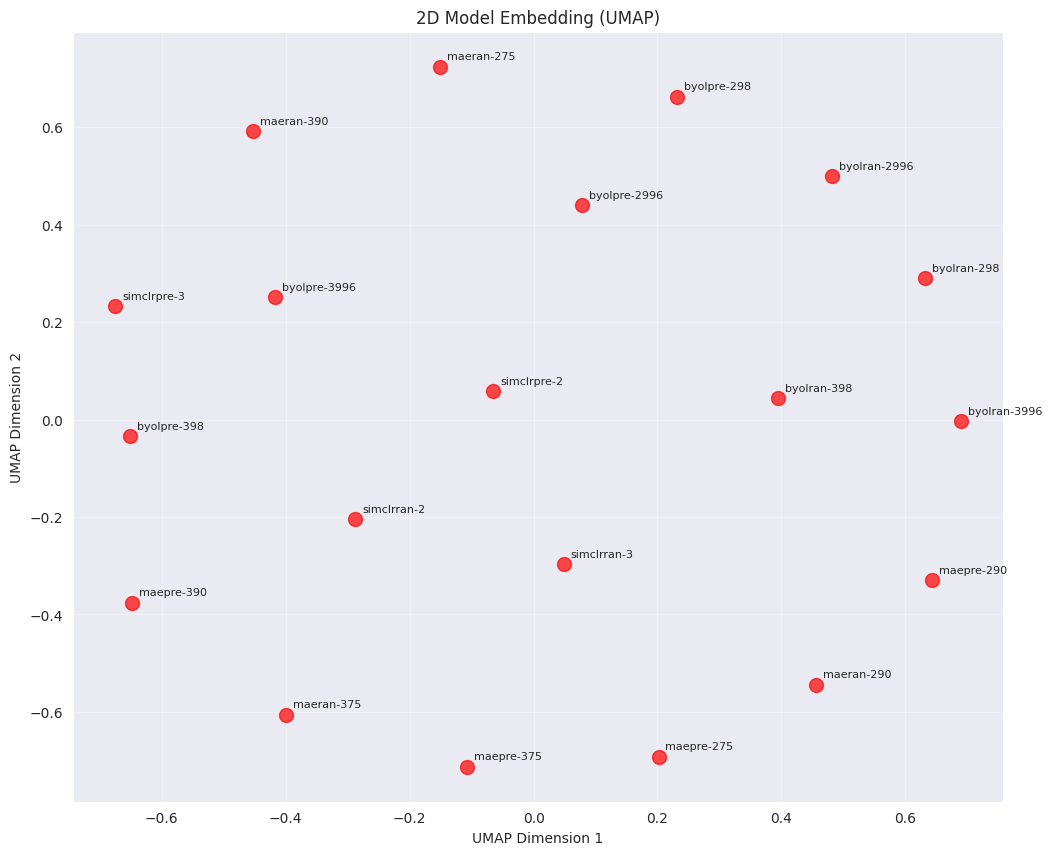

In [11]:
analyzer.plot_2d_embedding(method='umap')